Implementation of https://iopscience.iop.org/article/10.1088/1742-6596/1325/1/012079/pdf

In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import sklearn.model_selection
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

Small Concrete Dataset

<HDF5 group "/VSG" (4 members)>
<HDF5 group "/Vanilla" (4 members)>
Vanilla
Test R2:  0.3486162878810603
Test RMSE:  4.492914212173107
Train R2  0.9728366592673879
Train RMSE 1.277894236324157

VSG
Test R2:  0.362311748855641
Test RMSE:  4.431364337036644
Train R2  0.9762483393198427
Train RMSE 0.8631426301069178



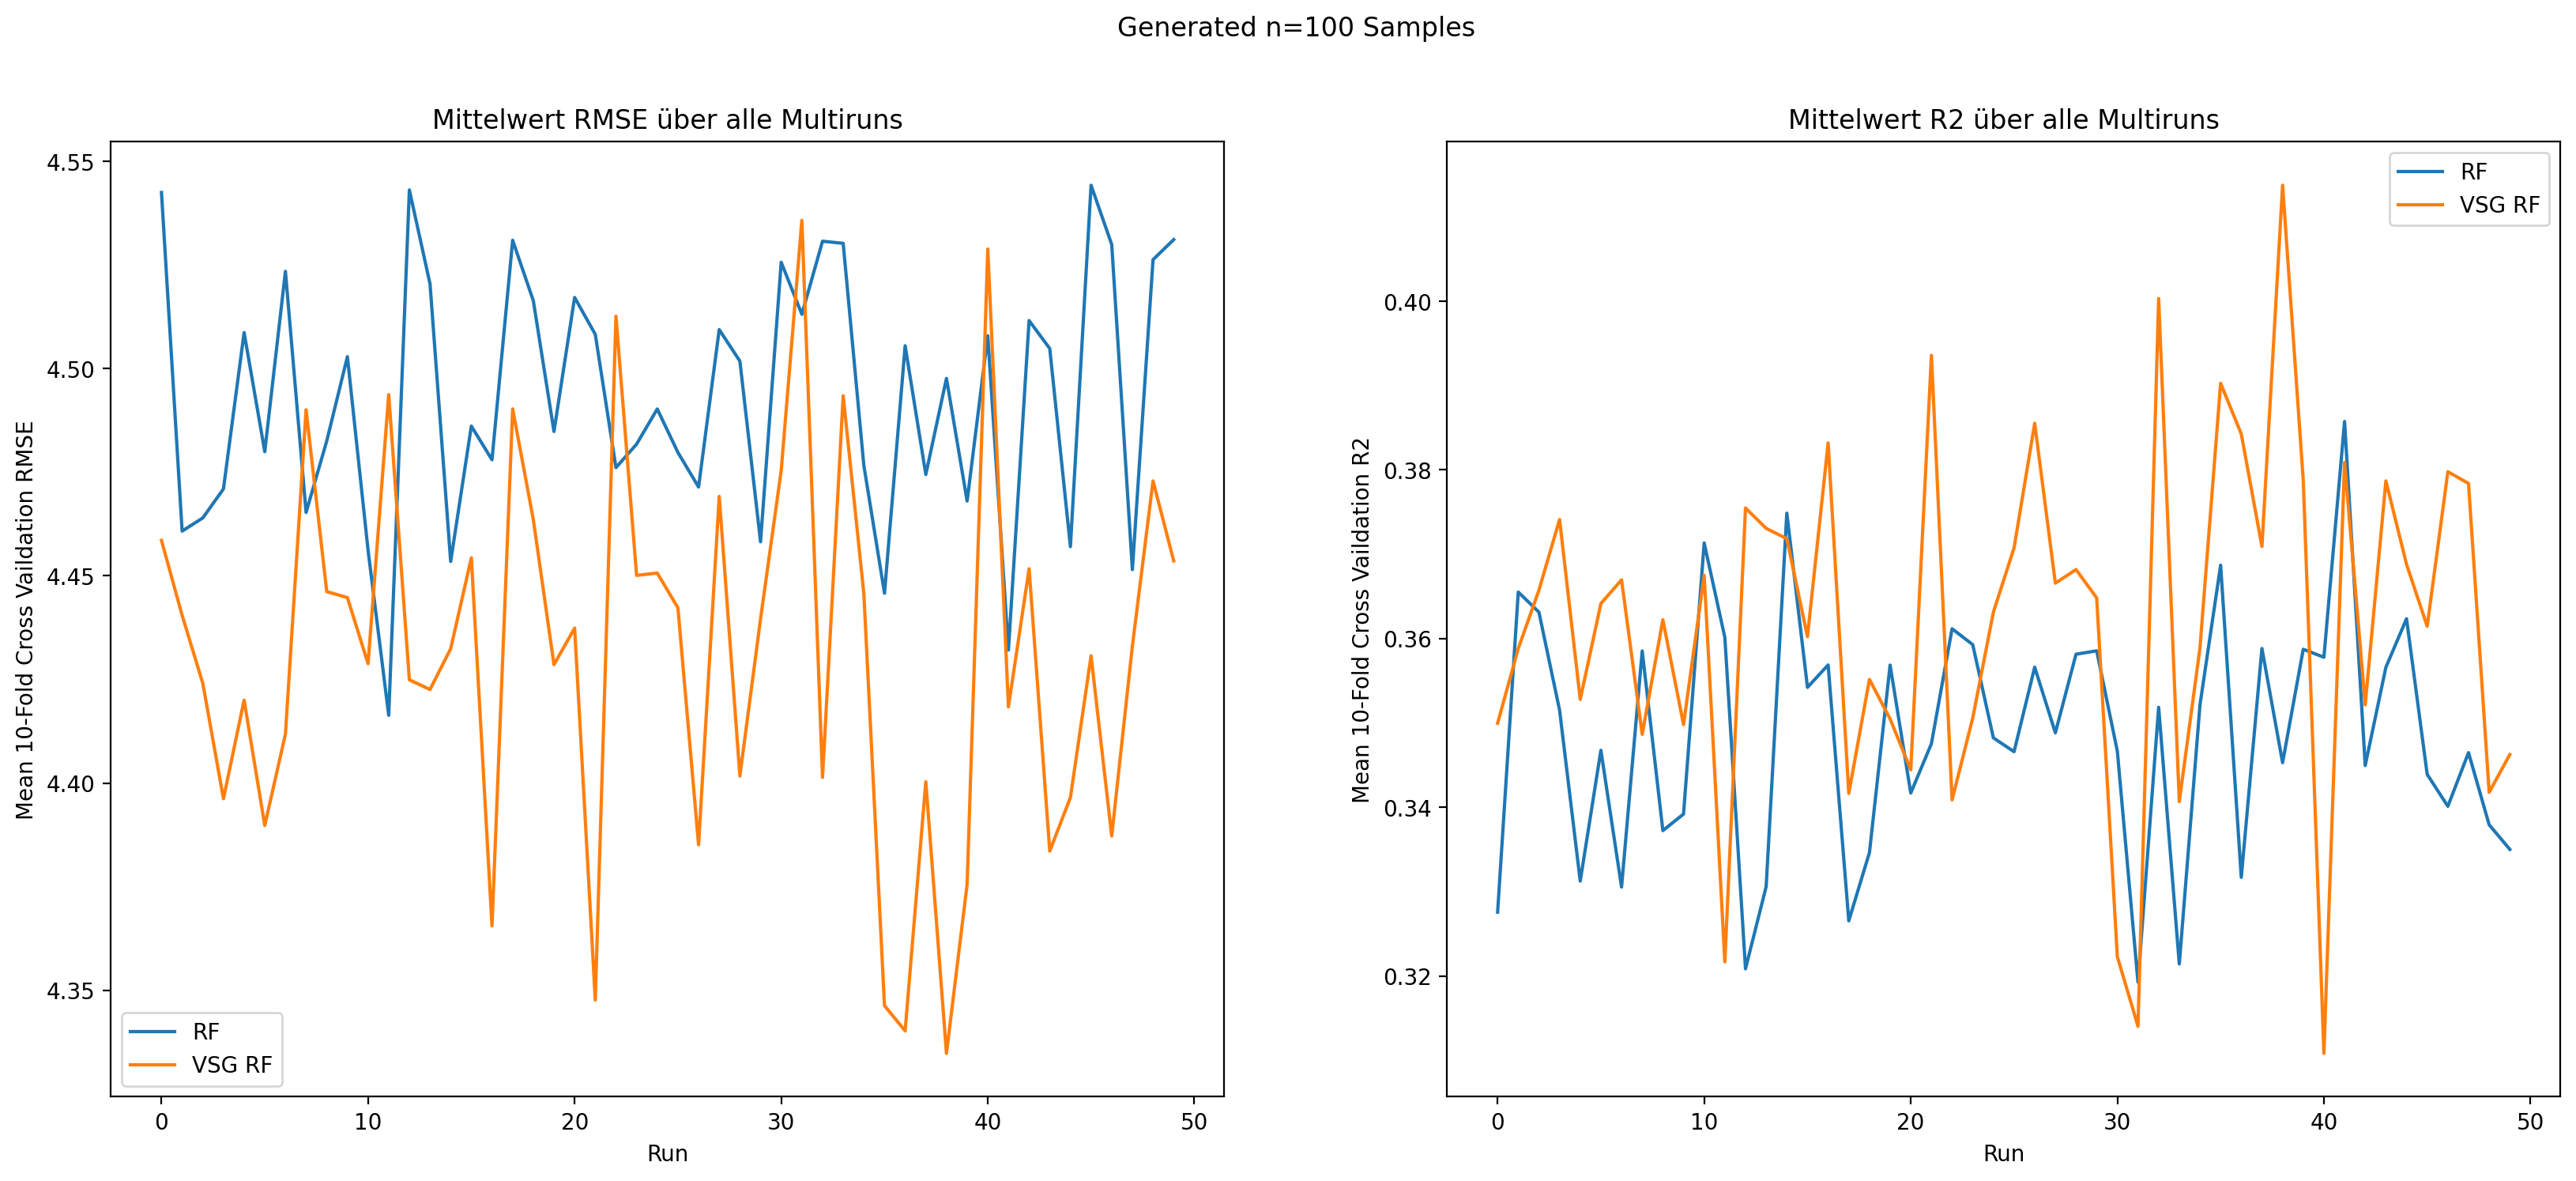

In [5]:
import h5py

def get_groupdata(groupkey):
    vanilla_data = []
    for key in groupkey.keys():
        vanilla_data.append(groupkey.get(key))
        
    testr2 = np.array(vanilla_data[0])
    testrmse = np.array(vanilla_data[1])
    trainr2 = np.array(vanilla_data[2])
    trainrmse = np.array(vanilla_data[3])
    return testr2, testrmse, trainr2, trainrmse
def print_things(testr2, testrmse, trainr2, trainrmse):
    print('Test R2: ', testr2.mean())
    print('Test RMSE: ', testrmse.mean())
    print('Train R2 ', trainr2.mean())
    print('Train RMSE', trainrmse.mean())


hf = h5py.File('/home/hoschangn/Schreibtisch/SoSe 2021/AutoML/MegaTrendDiffusion/vsg_augmentation_100.h5', 'r')

groups = []
for key in hf.keys():
    groups.append(hf.get(key))
    print(hf.get(key))

# Vanilla
testr2va, testrmseva, trainr2va, trainrmseva = get_groupdata(groups[1])
print('Vanilla')
print_things(testr2va, testrmseva, trainr2va, trainrmseva)
print()
# vsg... 100 extra datenpunkte
testr2w, testrmsew, trainr2w, trainrmsew = get_groupdata(groups[0])
print('VSG')
print_things(testr2w, testrmsew, trainr2w, trainrmsew)
print()

plt.figure(figsize=(20,8))
plt.suptitle('Generated n=100 Samples')
plt.subplot(1, 2, 1)
plt.title('Mittelwert RMSE über alle Multiruns')
plt.xlabel('Run')
plt.ylabel('Mean 10-Fold Cross Vaildation RMSE')
plt.plot(testrmseva.mean(axis=1), label='RF')
plt.plot(testrmsew.mean(axis=1), label = 'VSG RF')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Mittelwert R2 über alle Multiruns')
plt.xlabel('Run')
plt.ylabel('Mean 10-Fold Cross Vaildation R2')
plt.plot(testr2va.mean(axis=1), label='RF')
plt.plot(testr2w.mean(axis=1), label = 'VSG RF')
plt.legend()

<HDF5 group "/VSG" (4 members)>
<HDF5 group "/Vanilla" (4 members)>
Vanilla
Test R2:  0.3465737009170365
Test RMSE:  4.493160268617205
Train R2  0.9728624698744686
Train RMSE 1.2772851519695883

VSG
Test R2:  0.3748265212703211
Test RMSE:  4.397695208479803
Train R2  0.9769766140123018
Train RMSE 0.36945647042610724



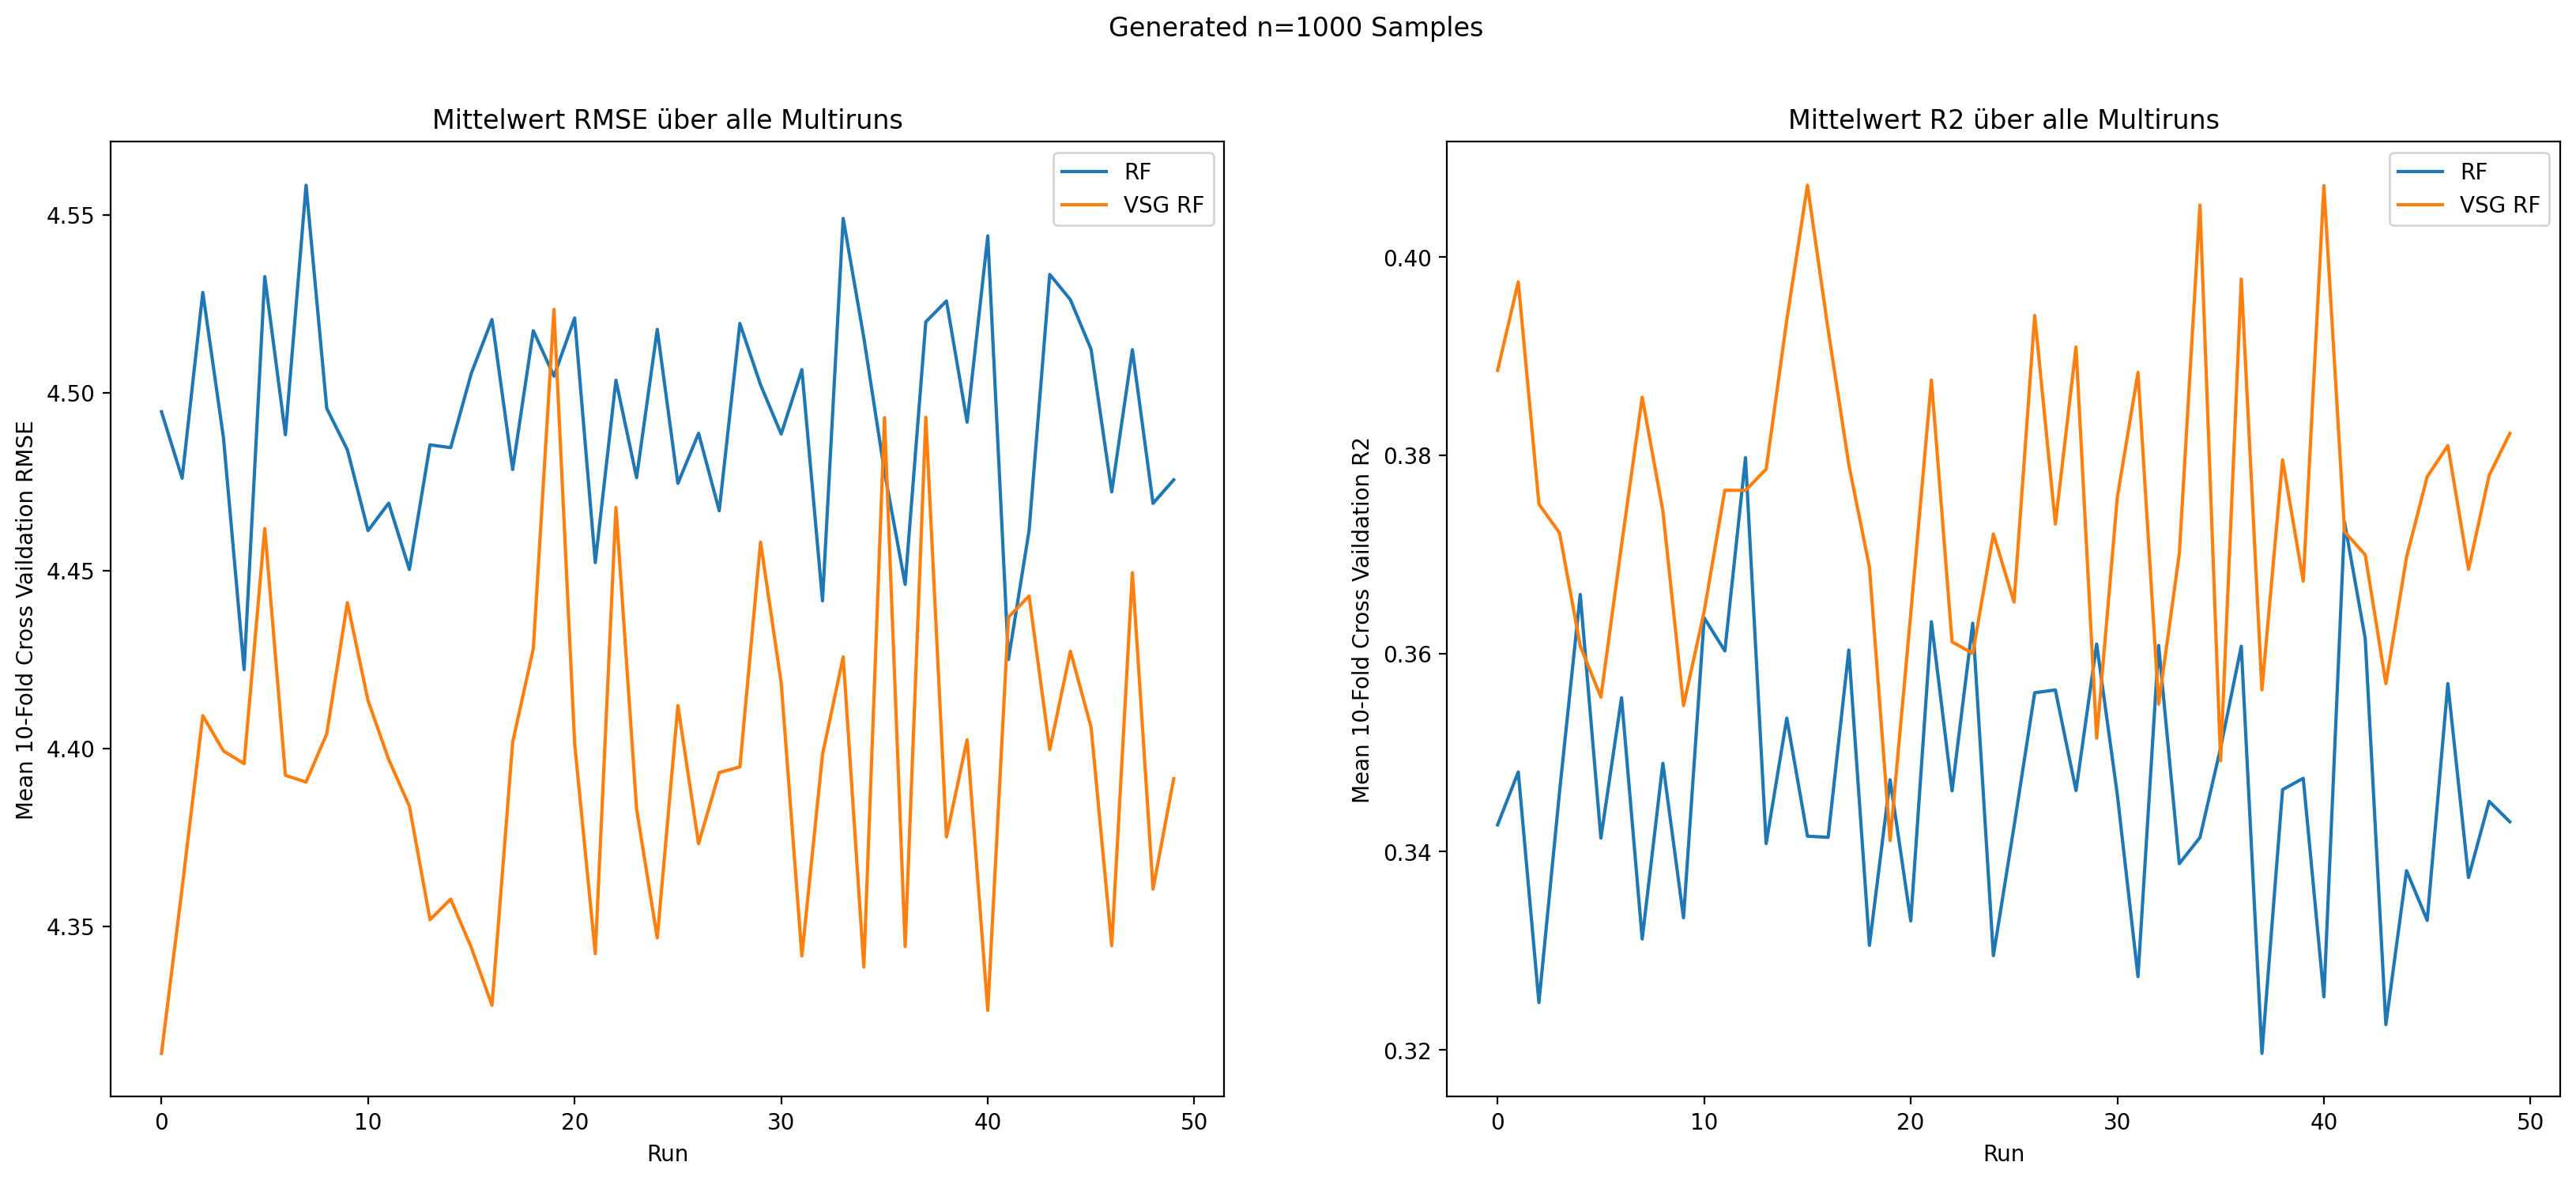

In [7]:
hf = h5py.File('/home/hoschangn/Schreibtisch/SoSe 2021/AutoML/MegaTrendDiffusion/vsg_augmentation_1000.h5', 'r')

groups = []
for key in hf.keys():
    groups.append(hf.get(key))
    print(hf.get(key))

# Vanilla
testr2va, testrmseva, trainr2va, trainrmseva = get_groupdata(groups[1])
print('Vanilla')
print_things(testr2va, testrmseva, trainr2va, trainrmseva)
print()
# vsg... 1000 extra datenpunkte
testr2w, testrmsew, trainr2w, trainrmsew = get_groupdata(groups[0])
print('VSG')
print_things(testr2w, testrmsew, trainr2w, trainrmsew)
print()

plt.figure(figsize=(20,8))
plt.suptitle('Generated n=1000 Samples')
plt.subplot(1, 2, 1)
plt.title('Mittelwert RMSE über alle Multiruns')
plt.xlabel('Run')
plt.ylabel('Mean 10-Fold Cross Vaildation RMSE')
plt.plot(testrmseva.mean(axis=1), label='RF')
plt.plot(testrmsew.mean(axis=1), label = 'VSG RF')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Mittelwert R2 über alle Multiruns')
plt.xlabel('Run')
plt.ylabel('Mean 10-Fold Cross Vaildation R2')
plt.plot(testr2va.mean(axis=1), label='RF')
plt.plot(testr2w.mean(axis=1), label = 'VSG RF')
plt.legend()

Big Concrete Dataset


<HDF5 group "/VSG" (4 members)>
<HDF5 group "/Vanilla" (4 members)>
Vanilla
Test R2:  0.7245825494383022
Test RMSE:  7.164659490426212
Train R2  0.9747079089018316
Train RMSE 2.64110216329915

VSG
Test R2:  0.7489100074765006
Test RMSE:  6.876017178868533
Train R2  0.97807039141515
Train RMSE 2.540686104327693



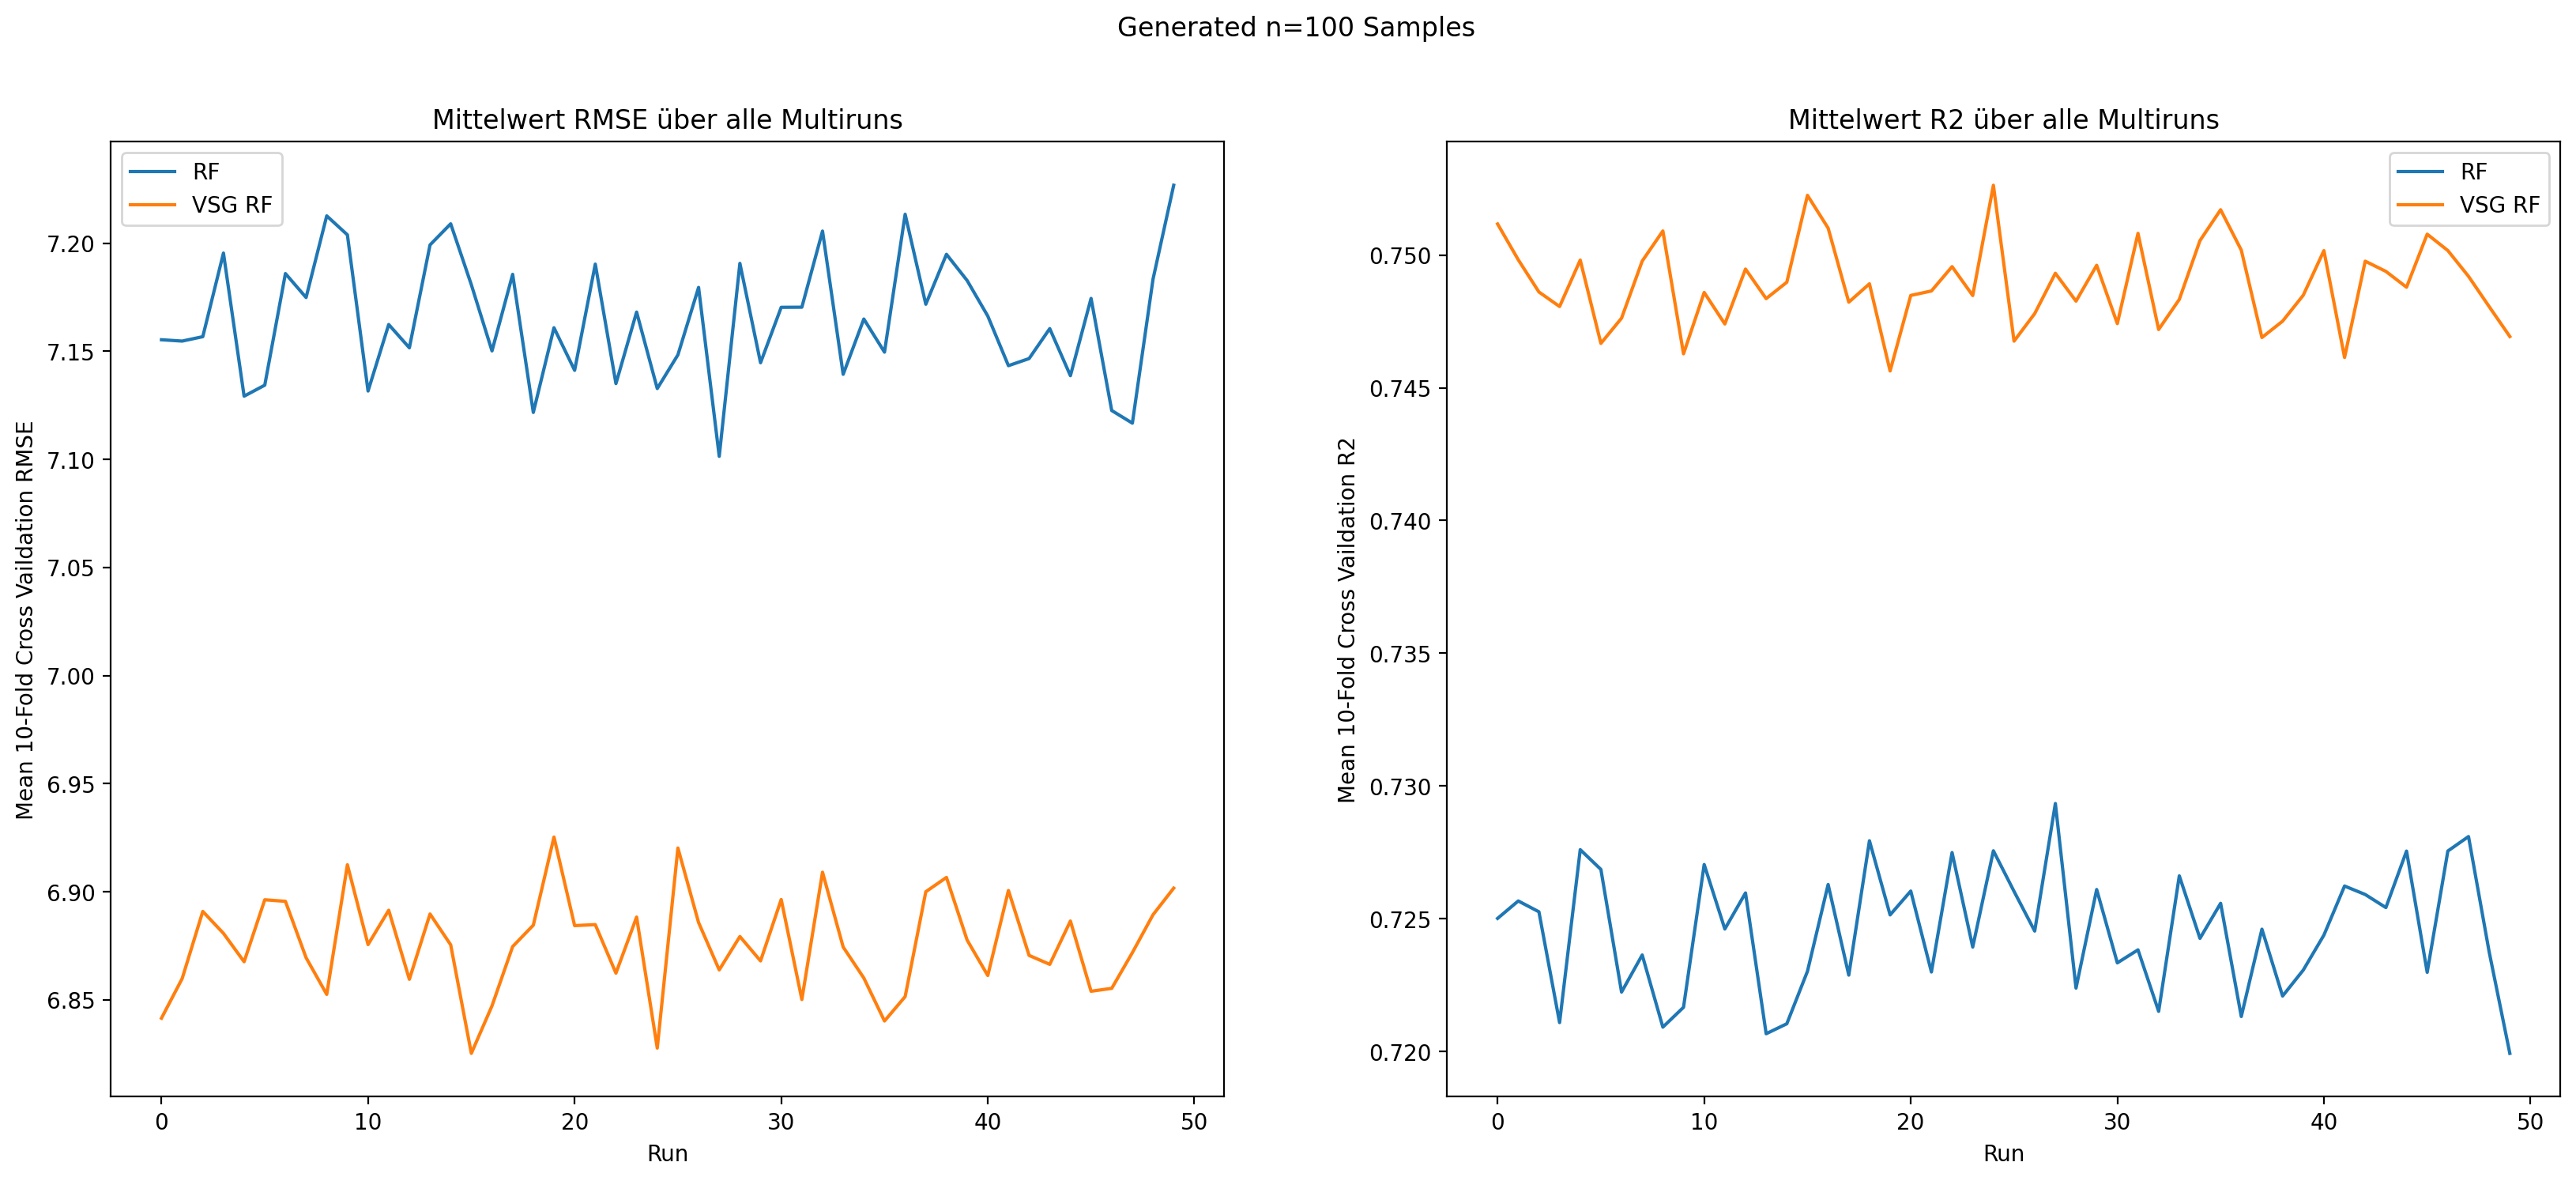

In [22]:
hf = h5py.File('/home/hoschangn/Schreibtisch/SoSe 2021/AutoML/MegaTrendDiffusion/vsg_augmentation_big_100.h5', 'r')

groups = []
for key in hf.keys():
    groups.append(hf.get(key))
    print(hf.get(key))

# Vanilla
testr2va, testrmseva, trainr2va, trainrmseva = get_groupdata(groups[1])
print('Vanilla')
print_things(testr2va, testrmseva, trainr2va, trainrmseva)
print()
# vsg... 100 extra datenpunkte
testr2w, testrmsew, trainr2w, trainrmsew = get_groupdata(groups[0])
print('VSG')
print_things(testr2w, testrmsew, trainr2w, trainrmsew)
print()

plt.figure(figsize=(20,8))
plt.suptitle('Generated n=100 Samples')
plt.subplot(1, 2, 1)
plt.title('Mittelwert RMSE über alle Multiruns')
plt.xlabel('Run')
plt.ylabel('Mean 10-Fold Cross Vaildation RMSE')
plt.plot(testrmseva.mean(axis=1), label='RF')
plt.plot(testrmsew.mean(axis=1), label = 'VSG RF')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Mittelwert R2 über alle Multiruns')
plt.xlabel('Run')
plt.ylabel('Mean 10-Fold Cross Vaildation R2')
plt.plot(testr2va.mean(axis=1), label='RF')
plt.plot(testr2w.mean(axis=1), label = 'VSG RF')
plt.legend()

<HDF5 group "/VSG" (4 members)>
<HDF5 group "/Vanilla" (4 members)>
Vanilla
Test R2:  0.7245972947220124
Test RMSE:  7.162074556271003
Train R2  0.9747139892169692
Train RMSE 2.640857572797053

VSG
Test R2:  0.7517470828566624
Test RMSE:  6.802653068037306
Train R2  0.9857795615031809
Train RMSE 1.901255758448419



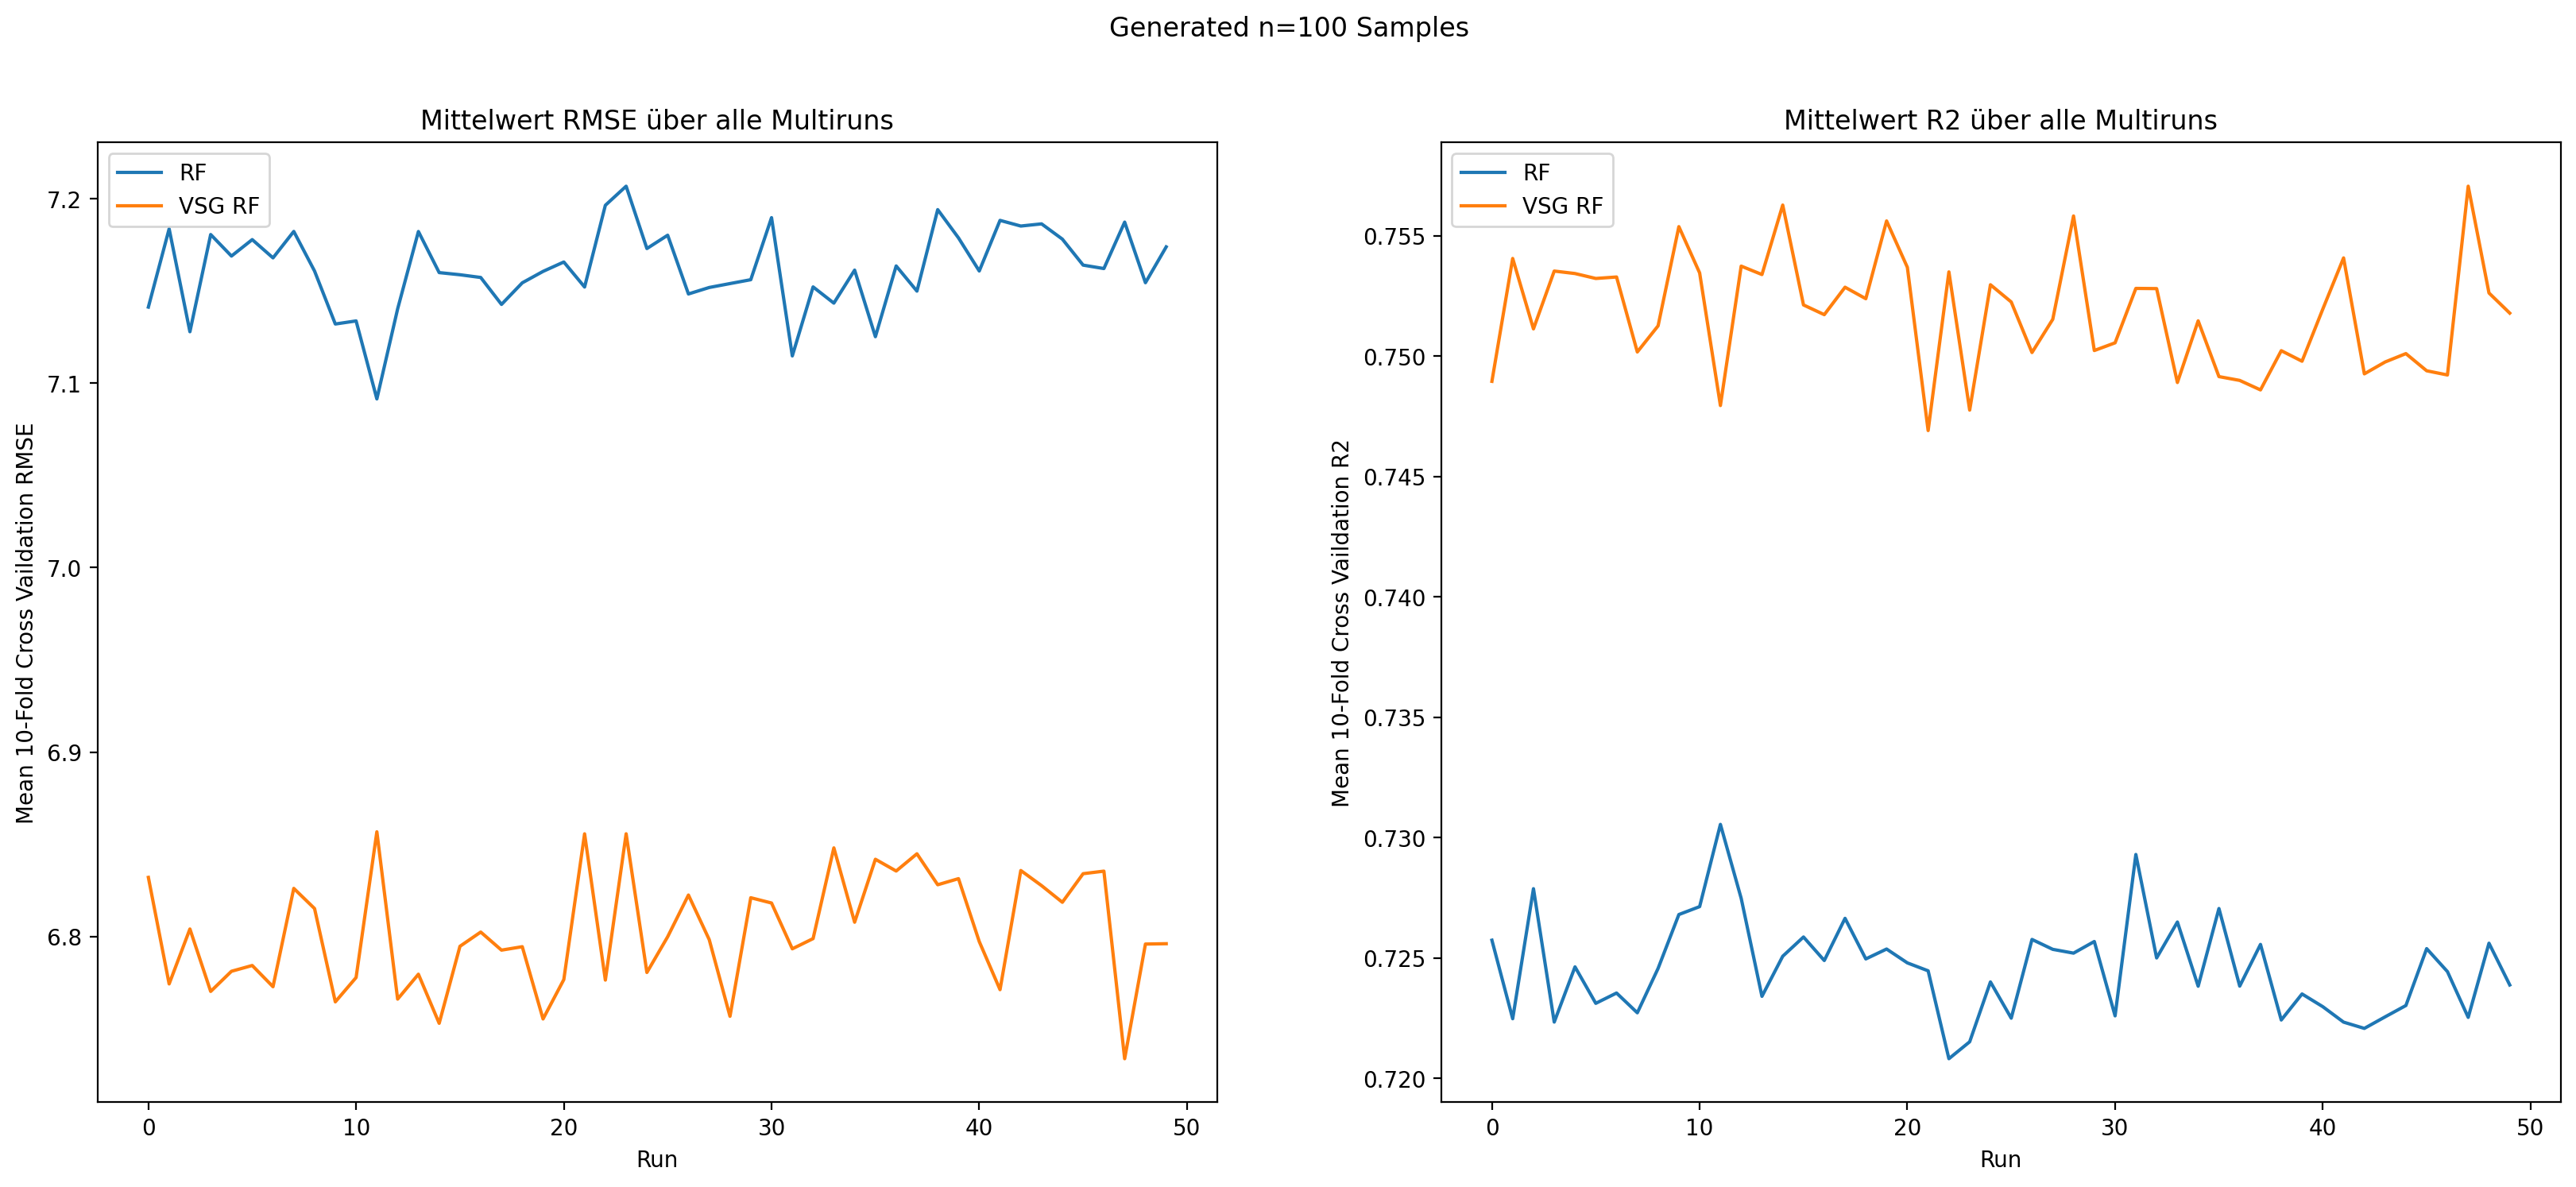

In [23]:
hf = h5py.File('/home/hoschangn/Schreibtisch/SoSe 2021/AutoML/MegaTrendDiffusion/vsg_augmentation_big_1000.h5', 'r')

groups = []
for key in hf.keys():
    groups.append(hf.get(key))
    print(hf.get(key))

# Vanilla
testr2va, testrmseva, trainr2va, trainrmseva = get_groupdata(groups[1])
print('Vanilla')
print_things(testr2va, testrmseva, trainr2va, trainrmseva)
print()
# vsg... 100 extra datenpunkte
testr2w, testrmsew, trainr2w, trainrmsew = get_groupdata(groups[0])
print('VSG')
print_things(testr2w, testrmsew, trainr2w, trainrmsew)
print()

plt.figure(figsize=(20,8))
plt.suptitle('Generated n=100 Samples')
plt.subplot(1, 2, 1)
plt.title('Mittelwert RMSE über alle Multiruns')
plt.xlabel('Run')
plt.ylabel('Mean 10-Fold Cross Vaildation RMSE')
plt.plot(testrmseva.mean(axis=1), label='RF')
plt.plot(testrmsew.mean(axis=1), label = 'VSG RF')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Mittelwert R2 über alle Multiruns')
plt.xlabel('Run')
plt.ylabel('Mean 10-Fold Cross Vaildation R2')
plt.plot(testr2va.mean(axis=1), label='RF')
plt.plot(testr2w.mean(axis=1), label = 'VSG RF')
plt.legend()